<a href="https://colab.research.google.com/github/Bhavana-Kolli/22035573_Final-Project_Stock-Market/blob/main/22035573_Data_Science_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [1]:
# Import libraries used

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from itertools import product
import matplotlib.dates as mdates

from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge


# Stocks were imported from Yahoo Finance using yfinance
import yfinance as yf


# **Functions**

In [2]:

# Function to plot the closing price, volume, and moving averages
def plot_stock_data(stock_data, stock_name="Stock"):
    """
    Plotting the closing price, volume, and moving averages for a given stock.
    """

    # Calculate moving averages
    stock_data['Close: 30 Day MA'] = stock_data['Close'].rolling(window=30).mean()
    stock_data['Close: 60 Day MA'] = stock_data['Close'].rolling(window=60).mean()
    stock_data['Close: 100 Day MA'] = stock_data['Close'].rolling(window=100).mean()

    plt.figure(figsize=(10, 12))

    # Plot the closing price
    plt.subplot(3, 1, 1)
    plt.plot(stock_data['Close'], label='Closing Price')
    plt.ylabel('Stock Prices')
    plt.xlabel('Year')
    plt.title(f"Closing Price of {stock_name} Stock")
    plt.legend()

    # Plot the trading volume
    plt.subplot(3, 1, 2)
    plt.plot(stock_data['Volume'], label='Volume Traded')
    plt.ylabel('Volume')
    plt.xlabel('Year')
    plt.title(f"Volume Traded for {stock_name} Stock in Past Decade")
    plt.legend()

    # Plot the moving averages
    plt.subplot(3, 1, 3)
    plt.plot(stock_data['Close'], label='Closing Price')
    plt.plot(stock_data['Close: 30 Day MA'], label='30 Day MA')
    plt.plot(stock_data['Close: 60 Day MA'], label='60 Day MA')
    plt.plot(stock_data['Close: 100 Day MA'], label='100 Day MA')
    plt.ylabel('Stock Prices')
    plt.xlabel('Year')
    plt.title(f"Moving Averages for {stock_name} Stock")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Function for Random Forest hyperparameter tuning
def randomforest_hyperparameter_tuning(X_train, y_train):
    """
    Performs hyperparameter tuning for a Random Forest Regressor using GridSearchCV.

    Returns: A Random Forest model with the best found hyperparameters.

    """
    # Define a dictionary of hyperparameters to tune
    param_grid = {
        # Number of trees in the forest
        'n_estimators': [50, 100, 150],
        # Maximum depth of each tree
        'max_depth': [None, 10, 20],
        # Minimum samples required to split a node
        'min_samples_split': [2, 5, 10]
    }
    # Initialize a Random Forest Regressor with random state as '40'
    rf = RandomForestRegressor(random_state=40)
    # Set up GridSearchCV with 5-fold cross-validation and negative MSE as the scoring metric
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    # Fit the grid search to find the best hyperparameters
    grid_search.fit(X_train, y_train)
    # Return the model with the best found parameters
    return grid_search.best_estimator_


# Function for Support Vector Machine (SVM) Hyperparameter tuning
def svm_hyperparameter_tuning(X_train, y_train):
    """
    Performs hyperparameter tuning for an SVM Regressor using GridSearchCV.

    Returns: An SVM model with the best found hyperparameters.

    """
    # Define a dictionary of hyperparameters to tune
    param_grid = {
        # Regularization parameter
        'C': [1, 10, 100],
        # Kernel coefficient
        'gamma': [0.01, 0.1, 1],
        # Epsilon in the epsilon-SVR model
        'epsilon': [0.1, 0.2, 0.5]
    }
    # Initialize an SVR model with radial basis function kernel
    svm = SVR(kernel='rbf')
    # Set up GridSearchCV with 5-fold cross-validation and negative MSE as the scoring metric
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    # Fit the grid search to find the best hyperparameters
    grid_search.fit(X_train, y_train)
    # Return the model with the best found parameters
    return grid_search.best_estimator_


# Function to create the hyperparameter grid for LSTM model
def lstm_hyperparameter_grid():
    """
    Create and return hyperparameter grid for tuning.
    Returns:  A list of parameter combinations.
    """
    # Define the ranges for the hyperparameters
    param_grid = {
        # Number of LSTM units to test
        "lstm_units": [32, 64, 128],
        # Batch sizes to test during training
        "batch_size": [32, 64, 128],
        # Learning rates to evaluate
        "learning_rate": [0.001, 0.0005, 0.0001]
    }
    # Generate all combinations of hyperparameter values using Cartesian product
    param_combinations = list(product(
        param_grid["lstm_units"],
        param_grid["batch_size"],
        param_grid["learning_rate"]
    ))
    return param_combinations


# Define a function to create and compile the LSTM model
def create_lstm_model(input_shape, lstm_units, learning_rate):
    """
    Creates and compiles an LSTM model.
    Args:
        input_shape: Shape of the input data.
        lstm_units: Number of LSTM units.
        learning_rate: Learning rate for optimizer.

    Returns:
        Compiled LSTM model.
    """
    model = Sequential([
        LSTM(lstm_units, activation='tanh', return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)  # Output layer for regression
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


def lstm_model_train_evaluate_and_predict(data, dates, look_back, param_combinations, company_name, days_to_predict=60):
    """
    Trains, tunes, evaluates an LSTM model, and generates future stock price predictions.

    Args:
        data (numpy.ndarray): Scaled stock price data.
        dates (pd.Series): Corresponding dates for the stock price data.
        look_back (int): The number of past days used for the sequence input.
        param_combinations (list): List of hyperparameter combinations.
        company_name (str): Name of the company for display purposes.
        days_to_predict (int): Number of days to predict into the future.

    Returns:
        dict: A dictionary containing the best model, RMSE, accuracy, and future predictions.
    """
    # Split data into training and testing
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size - look_back:]
    dates_test = dates[train_size:]

    # Create generators
    train_generator = TimeseriesGenerator(train_data, train_data, length=look_back, batch_size=10)
    test_generator = TimeseriesGenerator(test_data, test_data, length=look_back, batch_size=1)

    # Initialize variables to store the best model and results
    best_model = None
    lowest_rmse = float("inf")
    best_accuracy = 0
    best_params = None
    input_shape = (look_back, 1)
    mean_actual_value = np.mean(test_data[look_back:])

    # Hyperparameter tuning
    for lstm_units, batch_size, learning_rate in param_combinations:
        print(f"Testing combination: Units={lstm_units}, Batch={batch_size}, LR={learning_rate}")
        model = create_lstm_model(input_shape, lstm_units, learning_rate)
        model.fit(train_generator, epochs=5, batch_size=batch_size, verbose=0)

        # Predict and calculate metrics
        predicted_values = model.predict(test_generator, verbose=0)
        true_values = test_data[look_back:]
        rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
        accuracy_percentage = 100 - ((rmse / mean_actual_value) * 100)

        print(f"RMSE: {rmse:.4f}, Accuracy: {accuracy_percentage:.2f}%")

        if rmse < lowest_rmse:
            best_model = model
            lowest_rmse = rmse
            best_accuracy = accuracy_percentage
            best_params = (lstm_units, batch_size, learning_rate)

    # Train the best model
    print("\nTraining the best model with full data...")
    best_model.fit(train_generator, epochs=50, batch_size=best_params[1], verbose=1)

    # Predict on the test data and evaluate
    predicted_values = best_model.predict(test_generator, verbose=0)
    true_values = test_data[look_back:]
    mse = mean_squared_error(true_values, predicted_values)
    rmse = math.sqrt(mse)
    accuracy_percentage = 100 - ((rmse / mean_actual_value) * 100)

    # Print and plot results
    print(f"\n{company_name} LSTM Model Evaluation:")
    print(f"RMSE: {rmse:.4f}")
    print(f"Accuracy Percentage: {accuracy_percentage:.2f}%")

    plt.figure(figsize=(12, 6))
    plt.plot(dates_test[:len(true_values)], true_values, color='red', label=f'{company_name} Stock Price')
    plt.plot(dates_test[:len(predicted_values)], predicted_values, color='blue', label='Predicted Stock Price')
    plt.title(f'{company_name} Stock Price Prediction with LSTM Model')
    plt.xlabel('Date')
    plt.ylabel(f'{company_name} Stock Price')
    plt.legend()
    plt.show()

    # Future predictions
    last_sequence = data[-look_back:]
    future_predictions = []

    for _ in range(days_to_predict):
        input_sequence = last_sequence[-look_back:].reshape(1, look_back, 1)
        next_prediction = best_model.predict(input_sequence, verbose=0)[0, 0]
        future_predictions.append(next_prediction)
        last_sequence = np.append(last_sequence, next_prediction)
        last_sequence = last_sequence[-look_back:]

    # Inverse transform future predictions
    future_predictions_actual = scaler_bae.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Generate future dates
    last_date = dates.iloc[-1]
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=days_to_predict, freq='B')  # Business days

    # Create DataFrame for predictions
    future_predictions_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted Close': future_predictions_actual.flatten()
    })

    # Plot future predictions
    plt.figure(figsize=(12, 6))
    plt.plot(dates, scaler_bae.inverse_transform(data), label='Historical Close Prices')
    plt.plot(future_predictions_df['Date'], future_predictions_df['Predicted Close'], label='Future Predictions', color='red')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(f'{company_name} Stock Price Predictions for the Next {days_to_predict} Days')
    plt.show()

    # Return results
    return {
        "best_model": best_model,
        "best_params": best_params,
        "rmse": rmse,
        "accuracy_percentage": accuracy_percentage,
        "future_predictions": future_predictions_df
    }


def compares_model_accuracies(rf_accuracy, svm_accuracy, lstm_accuracy, stacking_accuracy, title):
    """
    Plots a horizontal bar chart comparing the accuracies of different models.

    """
    # Define accuracy percentages for each model
    model_accuracies = {
        'Random Forest': rf_accuracy,
        'SVM': svm_accuracy,
        'LSTM': lstm_accuracy,
        'Stacking Model': stacking_accuracy
    }

    # Convert the dictionary to a Pandas DataFrame for easier plotting
    accuracy_df = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=['Accuracy'])

    # Sort by accuracy for better visualization
    accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False)

    # Plot a horizontal bar plot for comparative accuracies
    plt.figure(figsize=(10, 6))
    plt.barh(accuracy_df.index, accuracy_df['Accuracy'], color=["#81D8D0", "#FFCC00", "#FF6666", "#66B2FF"])
    plt.title(title, fontsize=18, color="g")
    plt.xlabel('Accuracy Percentage', fontsize=15)
    plt.ylabel('Models', fontsize=15)

    # Add labels for each bar
    for i, acc in enumerate(accuracy_df['Accuracy']):
        plt.text(acc, i, f"{acc:.2f}%", va='center', ha='center')

    plt.show()

# **BAE Systems Plc**

## **Data Loading**

In [3]:
# Fetching the data of BAE Systems Plc from yahoo finance

# Define the ticker symbol
bae = "BA.L"

# Download the data for the specified date range
bae_data = yf.download(bae, start="2014-10-01", end="2024-10-01")

# Save the data to a CSV file
bae_data.to_csv('BAE_stock_data_10years.csv')

# Show the data
bae_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BA.L,BA.L,BA.L,BA.L,BA.L,BA.L
Date,,,,,,
2014-10-01,312.949219,463.200012,474.799988,462.100006,470.899994,6807389
2014-10-02,306.598267,453.799988,460.000000,453.000000,454.000000,9285952
2014-10-03,310.922302,460.200012,461.290985,453.299988,454.700012,6578201
2014-10-06,311.868225,461.600006,465.899994,458.500000,458.500000,6585452
2014-10-07,304.368744,450.500000,459.757996,445.000000,459.700012,11095801
...,...,...,...,...,...,...
2024-09-24,1255.620117,1267.500000,1276.500000,1261.849976,1273.500000,11342845
2024-09-25,1262.059204,1274.000000,1276.500000,1256.000000,1257.000000,6238942


In [4]:
# General information of BAE Systems Plc stock
bae_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2526 entries, 2014-10-01 to 2024-09-30
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, BA.L)  2526 non-null   float64
 1   (Close, BA.L)      2526 non-null   float64
 2   (High, BA.L)       2526 non-null   float64
 3   (Low, BA.L)        2526 non-null   float64
 4   (Open, BA.L)       2526 non-null   float64
 5   (Volume, BA.L)     2526 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 138.1 KB


In [5]:
# Summary stats for BAE Systems Plc stock
bae_data.describe()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BA.L,BA.L,BA.L,BA.L,BA.L,BA.L
count,2526.000000,2526.000000,2526.000000,2526.000000,2526.000000,2.526000e+03
mean,568.384831,659.810301,666.216326,653.037293,659.922097,7.983746e+06
std,268.185360,235.550137,237.705318,233.742489,235.675575,4.108558e+06
min,295.382935,397.000000,406.399994,5.694000,398.600006,0.000000e+00
25%,402.103752,505.000000,511.000000,499.491997,505.500000,5.408591e+06
50%,460.407684,569.300018,574.000000,564.333527,568.200012,7.127968e+06
75%,675.781189,731.549988,741.170502,718.350021,731.250015,9.637130e+06
max,1386.878296,1400.000000,1415.250000,1395.500000,1403.500000,5.421986e+07


In [6]:
# Print the number of rows in the original data
print('Rows in original data = %d' % (bae_data.shape[0]))

# Drop rows with missing values
df = bae_data.dropna()

# Print the number of rows after discarding missing values
print('Rows after discarding missing values = %d' % (df.shape[0]))

Rows in original data = 2526
Rows after discarding missing values = 2526


## **Preprocessing**

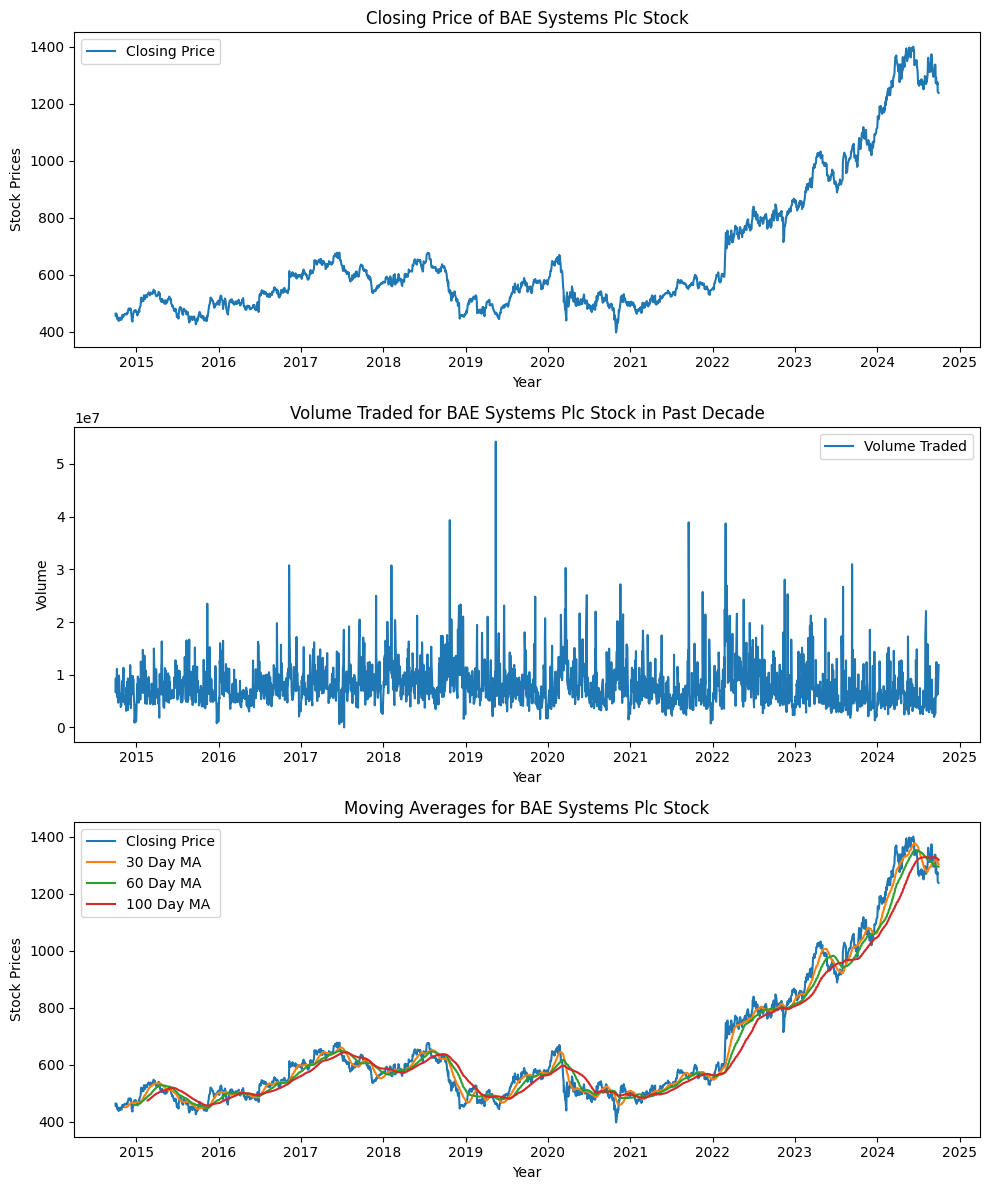

In [7]:
# Plotting the closing price, volume traded & moving averages for BAE Systems Plc stock over 10 years.
plot_stock_data(bae_data, stock_name="BAE Systems Plc")


In [8]:
# Predict next day's price
bae_data['Target'] = bae_data['Close'].shift(-1)
bae_data.dropna(inplace=True)
bae_data

Price,Adj Close,Close,High,Low,Open,Volume,Close: 30 Day MA,Close: 60 Day MA,Close: 100 Day MA,Target
Ticker,BA.L,BA.L,BA.L,BA.L,BA.L,BA.L,,,,
Date,,,,,,,,,,
2015-02-20,364.737488,530.0,532.000000,522.000000,526.0,6857203,509.086668,488.176668,474.275002,534.0
2015-02-23,367.490326,534.0,535.000000,530.500000,533.0,6518450,511.213334,489.180001,474.983001,536.0
2015-02-24,368.866669,536.0,540.775024,534.500000,540.5,7128877,513.243334,490.136668,475.805002,537.5
2015-02-25,369.898926,537.5,542.000000,535.500000,536.5,9559467,515.540000,491.076668,476.578001,533.0
2015-02-26,366.802094,533.0,542.500000,532.000000,539.5,6034292,517.320000,492.040001,477.292001,532.0
...,...,...,...,...,...,...,...,...,...,...
2024-09-23,1263.049927,1275.0,1275.500000,1260.000000,1266.0,8915378,1317.133333,1296.108333,1324.320000,1267.5
2024-09-24,1255.620117,1267.5,1276.500000,1261.849976,1273.5,11342845,1315.933333,1296.033333,1323.700000,1274.0


In [9]:
# Create a minmaxscaler object with a specific feature range
scaler_bae = MinMaxScaler(feature_range=(0, 1))
# Now normalize the 'Close' prices of Sainsbury stock and reshape it
scaled_data_bae = scaler_bae.fit_transform(bae_data['Close'].values.reshape(-1,1))

# Splitting the dataset for Random Forest and SVM models
X_bae = scaled_data_bae[:-1]  # Features
y_bae = scaled_data_bae[1:]  # Targets

# Allocating 20% of the dataset for testing, while 80% is used for training.
X_train_bae, X_test_bae, y_train_bae, y_test_bae = train_test_split(X_bae, y_bae,
                                                                    test_size=0.2,
                                                                    random_state=40,
                                                                    shuffle=False)

# Reshape for compatibility
y_train_bae = y_train_bae.ravel()
y_test_bae_1d = y_test_bae.ravel()

# Training size
train_size_bae = int(len(scaled_data_bae) * 0.8)

# The 'Date' column in the dataset is converted to datetime
bae_data['Date'] = bae_data.index
bae_data['Date'] = pd.to_datetime(bae_data['Date'])
dates_test_bae = bae_data['Date'][train_size_bae:]
# Ensure the shapes of dates_test_bae and y_test_bae align
dates_test_bae_align = dates_test_bae[:len(y_test_bae)]

## **Model Development**

### **Random Forest Model**

In [10]:
# Random Forest model for BAE Systems Plc stock
randomforest_bae = randomforest_hyperparameter_tuning(X_train_bae, y_train_bae)


Evaluating Random Forest model...
RMSE of Random Forest model for BAE Systems Plc Stock: 0.3138390861130026
Percentage Accuracy of Random Forest model for BAE Systems Plc Stock: 54.16%


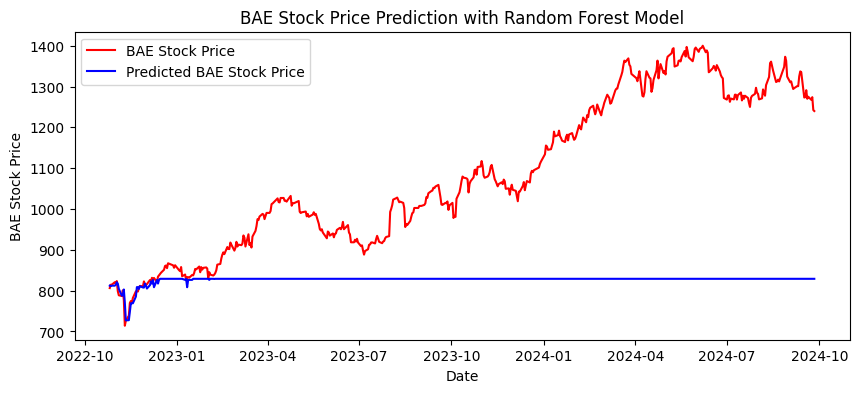

In [11]:
# Calculating mse, rmse, accuracy percentage for BAE Systems Plc stock with Random Forest model

# Evaluate the model on test data
randomforest_predictions = randomforest_bae.predict(X_test_bae)
# Calculating the Mean Squared Error on the test data
randomforest_mse_bae = mean_squared_error(y_test_bae, randomforest_predictions)
# Calculating the Root Mean Squared Error (RMSE) from MSE
randomforest_rmse_bae = math.sqrt(randomforest_mse_bae)
# Calculating the accuracy percentage
rf_accuracy_bae = 100 - ((randomforest_rmse_bae / np.mean(y_test_bae)) * 100)

# Printing the RMSE and Accuracy Percentage for the Random Forest model
print("Evaluating Random Forest model...")
print(f"RMSE of Random Forest model for BAE Systems Plc Stock: {randomforest_rmse_bae}")
print(f"Percentage Accuracy of Random Forest model for BAE Systems Plc Stock: {rf_accuracy_bae:.2f}%")


# Plotting actual vs predicted for Random Forest model
plt.figure(figsize=(10, 4))
# Inverse transform both y_test and predictions to original scale
plt.plot(dates_test_bae_align, scaler_bae.inverse_transform(y_test_bae.reshape(-1, 1)),
         color='red', label='BAE Stock Price')
plt.plot(dates_test_bae_align, scaler_bae.inverse_transform(randomforest_predictions.reshape(-1, 1)),
         color='blue', label='Predicted BAE Stock Price')
plt.title('BAE Stock Price Prediction with Random Forest Model')
plt.xlabel('Date')
plt.ylabel('BAE Stock Price')
plt.legend()
plt.show()



### **SVM Model**

In [12]:
# SVM model for BAE Systems Plc stock
svm_model_bae = svm_hyperparameter_tuning(X_train_bae, y_train_bae)


Evaluating SVM model...
RMSE of SVM model for BAE Systems Plc Stock: 0.19414421801746207
Percentage Accuracy of SVM model for BAE Systems Plc Stock: 71.64%


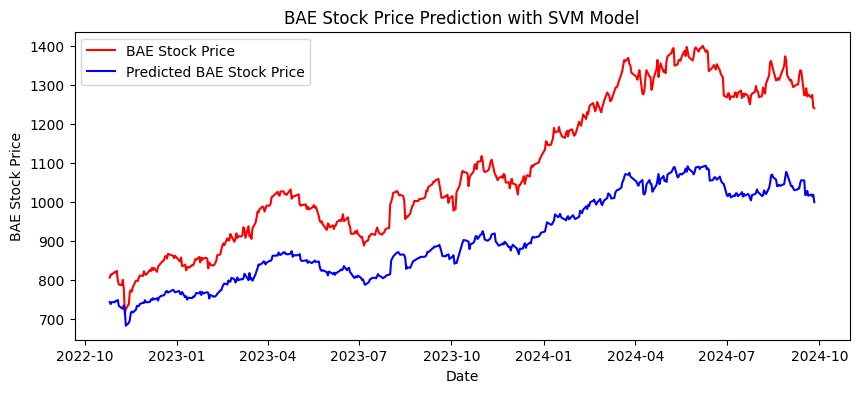

In [13]:
# Calculating mse, rmse, accuracy percentage for BAE Systems Plc stock with SVM model

# Evaluate the model on test data
svm_predictions = svm_model_bae.predict(X_test_bae)
# Calculating the Mean Squared Error on the test data
svm_mse_bae = mean_squared_error(y_test_bae, svm_predictions)
# Calculating the Root Mean Squared Error (RMSE) from MSE
svm_rmse_bae = math.sqrt(svm_mse_bae)
# Calculating the accuracy percentage
svm_accuracy_bae = 100 - ((svm_rmse_bae / np.mean(y_test_bae)) * 100)

# Print the RMSE and Accuracy Percentage for SVM model
print("Evaluating SVM model...")
print(f"RMSE of SVM model for BAE Systems Plc Stock: {svm_rmse_bae}")
print(f"Percentage Accuracy of SVM model for BAE Systems Plc Stock: {svm_accuracy_bae:.2f}%")

# Plotting actual vs predicted for SVM model
plt.figure(figsize=(10, 4))
# Inverse transform both y_test and predictions to original scale
plt.plot(dates_test_bae_align, scaler_bae.inverse_transform(y_test_bae.reshape(-1, 1)),
         color='red', label='BAE Stock Price')
plt.plot(dates_test_bae_align, scaler_bae.inverse_transform(svm_predictions.reshape(-1, 1)),
         color='blue', label='Predicted BAE Stock Price')
plt.title('BAE Stock Price Prediction with SVM Model')
plt.xlabel('Date')
plt.ylabel('BAE Stock Price')
plt.legend()
plt.show()



### **LSTM Model**

Testing combination: Units=32, Batch=32, LR=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


RMSE: 0.0253, Accuracy: 96.30%
Testing combination: Units=32, Batch=32, LR=0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0323, Accuracy: 95.28%
Testing combination: Units=32, Batch=32, LR=0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0516, Accuracy: 92.46%
Testing combination: Units=32, Batch=64, LR=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0402, Accuracy: 94.13%
Testing combination: Units=32, Batch=64, LR=0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0392, Accuracy: 94.26%
Testing combination: Units=32, Batch=64, LR=0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0526, Accuracy: 92.31%
Testing combination: Units=32, Batch=128, LR=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0639, Accuracy: 90.66%
Testing combination: Units=32, Batch=128, LR=0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0246, Accuracy: 96.41%
Testing combination: Units=32, Batch=128, LR=0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0406, Accuracy: 94.06%
Testing combination: Units=64, Batch=32, LR=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0478, Accuracy: 93.01%
Testing combination: Units=64, Batch=32, LR=0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0242, Accuracy: 96.47%
Testing combination: Units=64, Batch=32, LR=0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.1198, Accuracy: 82.49%
Testing combination: Units=64, Batch=64, LR=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0222, Accuracy: 96.75%
Testing combination: Units=64, Batch=64, LR=0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0305, Accuracy: 95.54%
Testing combination: Units=64, Batch=64, LR=0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.1059, Accuracy: 84.52%
Testing combination: Units=64, Batch=128, LR=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0556, Accuracy: 91.88%
Testing combination: Units=64, Batch=128, LR=0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0240, Accuracy: 96.49%
Testing combination: Units=64, Batch=128, LR=0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0674, Accuracy: 90.15%
Testing combination: Units=128, Batch=32, LR=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0312, Accuracy: 95.44%
Testing combination: Units=128, Batch=32, LR=0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0288, Accuracy: 95.79%
Testing combination: Units=128, Batch=32, LR=0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0845, Accuracy: 87.64%
Testing combination: Units=128, Batch=64, LR=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0207, Accuracy: 96.97%
Testing combination: Units=128, Batch=64, LR=0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0394, Accuracy: 94.25%
Testing combination: Units=128, Batch=64, LR=0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0382, Accuracy: 94.42%
Testing combination: Units=128, Batch=128, LR=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0298, Accuracy: 95.64%
Testing combination: Units=128, Batch=128, LR=0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0457, Accuracy: 93.31%
Testing combination: Units=128, Batch=128, LR=0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RMSE: 0.0862, Accuracy: 87.41%

Training the best model with full data...
Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4657e-04
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4893e-04
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6622e-04
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8027e-04
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9667e-04
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3369e-04
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9102e-04
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8006e-04
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4083e-04
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0213e-04
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0190e-04
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8541e-04
Epoch 13/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7113e-04

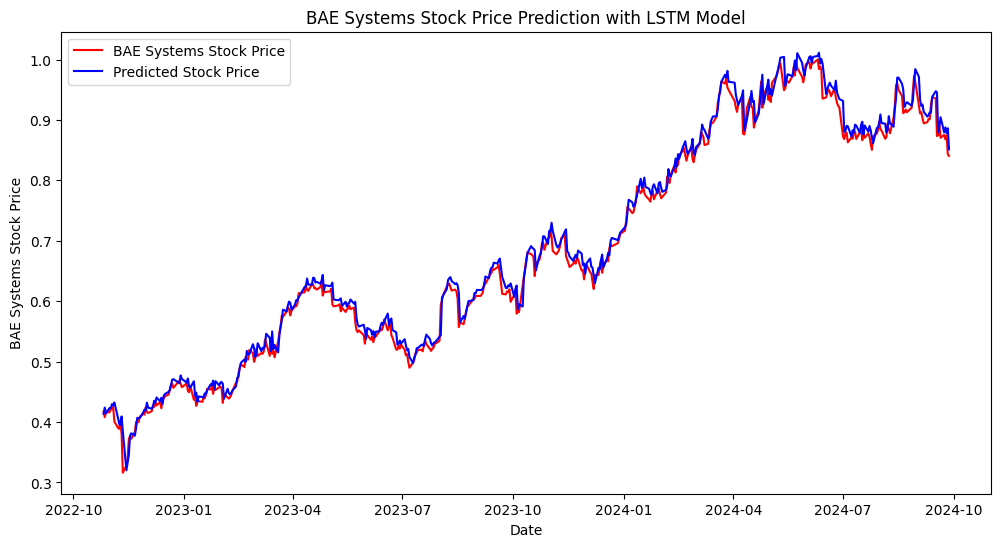

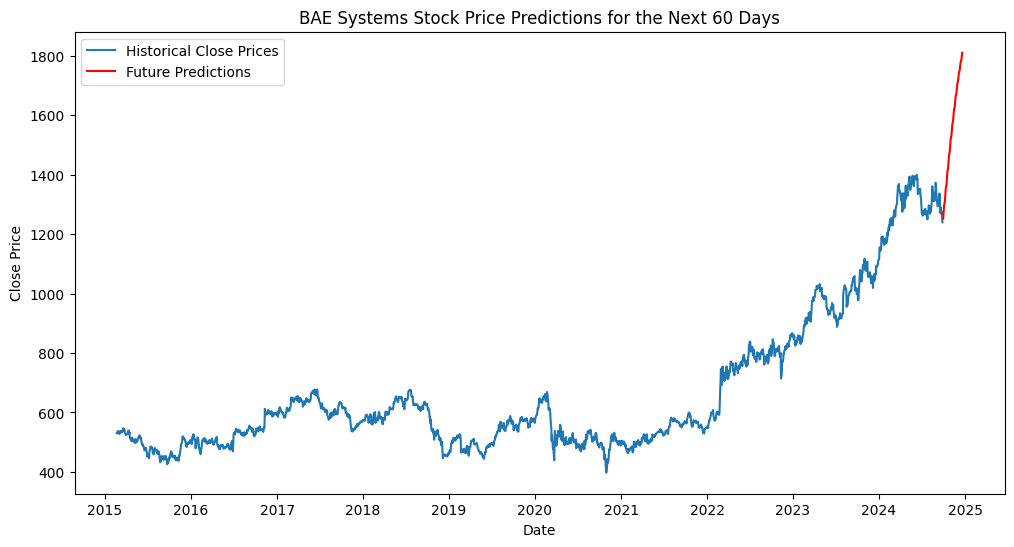

In [14]:
# LSTM model for BAE Systems Plc stock

# Get the hyperparameter combinations
param_combinations_bae = lstm_hyperparameter_grid()

# Train, Evaluate and Predict for BAE Systems LSTM model
bae_results = lstm_model_train_evaluate_and_predict(scaled_data_bae,
                                                    bae_data['Date'],
                                                    look_back=70,
                                                    param_combinations=param_combinations_bae,
                                                    company_name="BAE Systems",
                                                    days_to_predict=60)

# Retrieve the best model and other details from bae_results
best_lstm_bae = bae_results["best_model"]
best_params_bae = bae_results["best_params"]
lstm_rmse_bae = bae_results["rmse"]
lstm_accuracy_bae = bae_results["accuracy_percentage"]
future_predictions_bae = bae_results["future_predictions"]


### **Stacking Model**

 80/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Evaluating Stacking Model...
RMSE of Stacking Model for BAE Systems Plc Stock: 0.1574
Accuracy Percentage of Stacking Model for BAE Systems Plc Stock: 77.02%


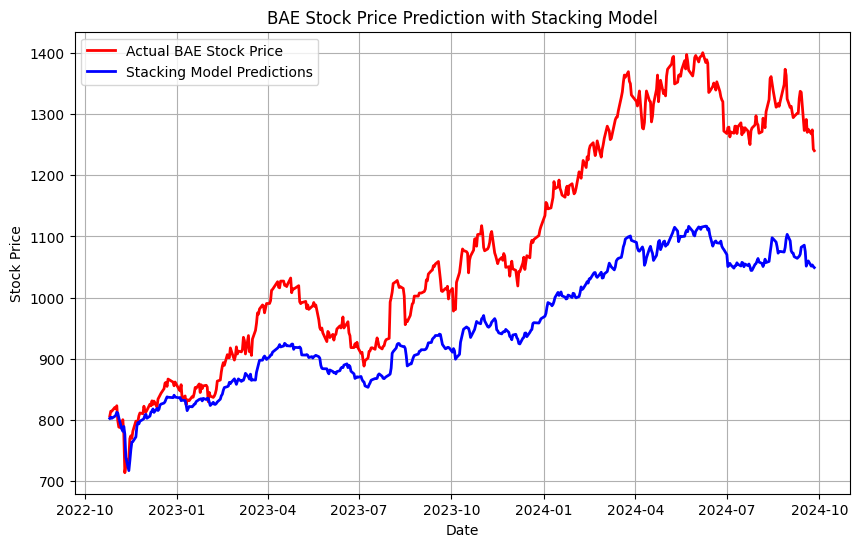

In [18]:
# Helper function to trim arrays to the same minimum length
def trim_to_min_length(*arrays):
    min_length = min(len(arr) for arr in arrays)
    return [arr[:min_length] for arr in arrays]

# Align training predictions
rf_train_predictions, svm_train_predictions, lstm_train_predictions = trim_to_min_length(
    randomforest_bae.predict(X_train_bae)[70:],
    svm_model_bae.predict(X_train_bae)[70:],
    best_lstm_bae.predict(
        TimeseriesGenerator(scaled_data_bae[:train_size_bae], scaled_data_bae[:train_size_bae], length=70, batch_size=10)
    ).flatten()
)

# Combine training meta-features
train_meta_features = np.column_stack((rf_train_predictions, svm_train_predictions, lstm_train_predictions))
aligned_y_train_bae = y_train_bae[70:]

# Align testing predictions
rf_test_predictions, svm_test_predictions, lstm_test_predictions = trim_to_min_length(
    randomforest_predictions,
    svm_predictions,
    best_lstm_bae.predict(
        TimeseriesGenerator(scaled_data_bae[train_size_bae - 70:], scaled_data_bae[train_size_bae - 70:], length=70, batch_size=1)
    ).flatten()
)

# Combine testing meta-features
test_meta_features = np.column_stack((rf_test_predictions, svm_test_predictions, lstm_test_predictions))
aligned_y_test_bae = y_test_bae[:len(test_meta_features)]

# Train Ridge Regressor as the meta-learner
meta_learner = Ridge(alpha=1.0)
meta_learner.fit(train_meta_features, aligned_y_train_bae)

# Evaluate Stacking Model
stacking_predictions = meta_learner.predict(test_meta_features)
stacking_mse = mean_squared_error(aligned_y_test_bae, stacking_predictions)
stacking_rmse = math.sqrt(stacking_mse)
stacking_accuracy = 100 - ((stacking_rmse / np.mean(aligned_y_test_bae)) * 100)

# Print Stacking Model Results
print("\nEvaluating Stacking Model...")
print(f"RMSE of Stacking Model for BAE Systems Plc Stock: {stacking_rmse:.4f}")
print(f"Accuracy Percentage of Stacking Model for BAE Systems Plc Stock: {stacking_accuracy:.2f}%")

# Plot actual vs predicted for the Stacking Model
plt.figure(figsize=(10, 6))
plt.plot(dates_test_bae_align[:len(aligned_y_test_bae)],
         scaler_bae.inverse_transform(aligned_y_test_bae.reshape(-1, 1)),
         label='Actual BAE Stock Price', color='red', linewidth=2)

plt.plot(dates_test_bae_align[:len(stacking_predictions)],
         scaler_bae.inverse_transform(stacking_predictions.reshape(-1, 1)),
         label='Stacking Model Predictions', color='blue', linewidth=2)

plt.title('BAE Stock Price Prediction with Stacking Model')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()


## **Comparing Models**

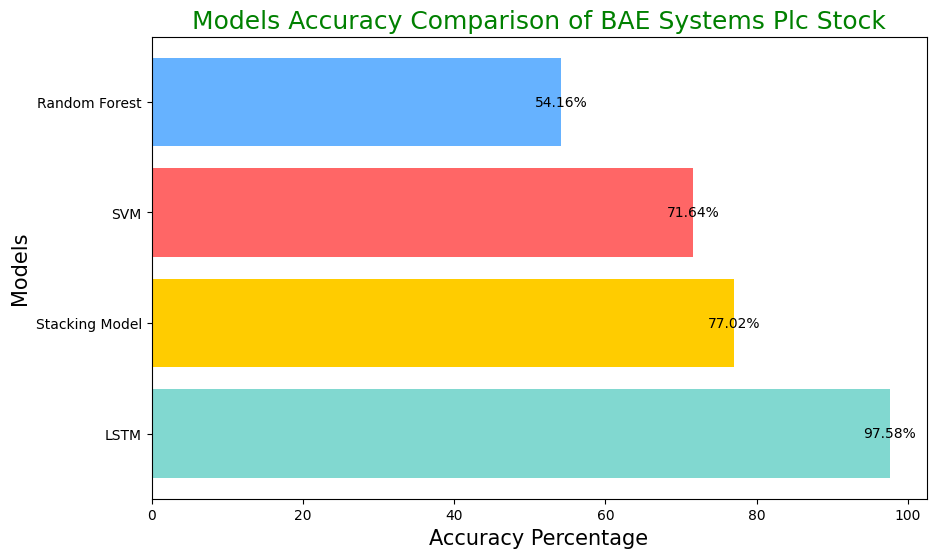

In [19]:
compares_model_accuracies(
    rf_accuracy=rf_accuracy_bae,
    svm_accuracy=svm_accuracy_bae,
    lstm_accuracy=lstm_accuracy_bae,
    stacking_accuracy=stacking_accuracy,
    title="Models Accuracy Comparison of BAE Systems Plc Stock"
)

# **Lockheed Martin Corporation**

## **Data Loading**

In [ ]:
# Fetching the data of Lockheed Martin Corporation from yahoo finance

# Define the ticker symbol
lmt = "LMT"

# Download the data for the specified date range
lmt_data = yf.download(lmt, start="2014-10-01", end="2024-10-01")

# Save the data to a CSV file
lmt_data.to_csv('LMT_stock_data_10years.csv')

# Show the data
lmt_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,LMT,LMT,LMT,LMT,LMT,LMT
Date,,,,,,
2014-10-01 00:00:00+00:00,135.842224,177.889999,181.149994,177.080002,181.149994,1901400
2014-10-02 00:00:00+00:00,134.666260,176.350006,178.300003,175.789993,177.660004,1468900
2014-10-03 00:00:00+00:00,136.185898,178.339996,179.339996,176.919998,177.669998,2463700
2014-10-06 00:00:00+00:00,135.101517,176.919998,179.699997,176.669998,179.619995,1486300
2014-10-07 00:00:00+00:00,132.123322,173.020004,176.559998,173.000000,176.399994,1182700
...,...,...,...,...,...,...
2024-09-24 00:00:00+00:00,578.630005,578.630005,581.159973,576.150024,578.929993,690100
2024-09-25 00:00:00+00:00,577.940002,577.940002,583.750000,576.859985,581.559998,844500


In [ ]:
# General information of Lockheed Martin Corporation stock
lmt_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-10-01 00:00:00+00:00 to 2024-09-30 00:00:00+00:00
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Adj Close, LMT)  2516 non-null   float64
 1   (Close, LMT)      2516 non-null   float64
 2   (High, LMT)       2516 non-null   float64
 3   (Low, LMT)        2516 non-null   float64
 4   (Open, LMT)       2516 non-null   float64
 5   (Volume, LMT)     2516 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


In [ ]:
# Summary stats for Lockheed Martin Corporation stock
lmt_data.describe()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,LMT,LMT,LMT,LMT,LMT,LMT
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,306.487705,342.782615,345.657087,339.867643,342.768052,1.395195e+06
std,102.407656,91.496614,92.353775,90.646554,91.483846,9.144642e+05
min,131.810257,172.610001,173.850006,166.279999,170.149994,3.133000e+05
25%,220.717670,268.059990,269.892494,267.227509,268.555000,9.292000e+05
50%,310.543655,346.470001,350.099991,343.174988,346.870010,1.174250e+06
75%,385.352341,415.622513,420.035004,411.397491,415.955002,1.554625e+06
max,584.559998,584.559998,584.950012,579.210022,584.140015,1.396230e+07


In [ ]:
# Print the number of rows in the original data
print('Rows in original data = %d' % (lmt_data.shape[0]))

# Drop rows with missing values
df = lmt_data.dropna()

# Print the number of rows after discarding missing values
print('Rows after discarding missing values = %d' % (df.shape[0]))

Rows in original data = 2516
Rows after discarding missing values = 2516


## **Data Preprocessing**

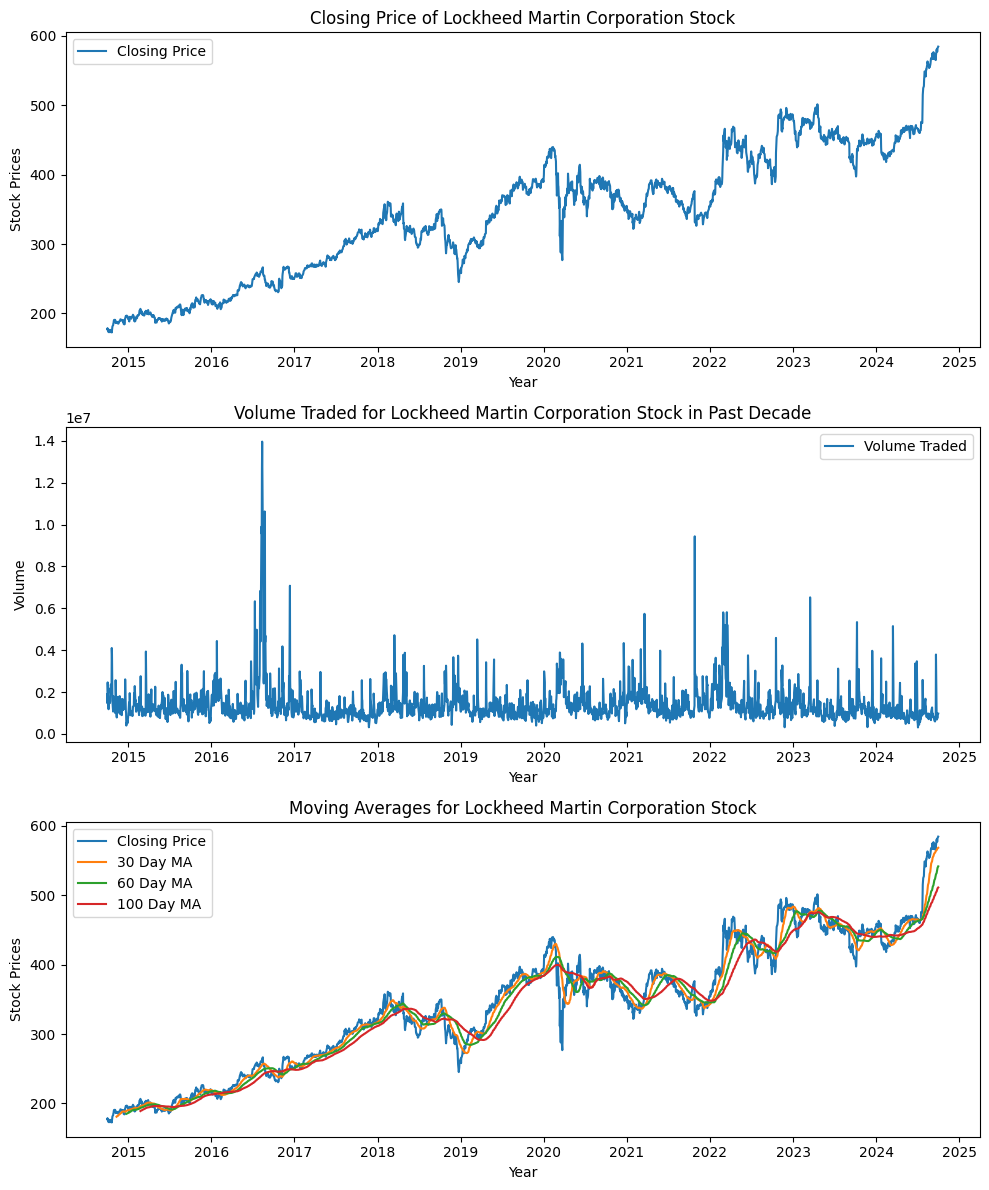

In [ ]:
# Plotting the closing price, volume traded & moving averages for Lockheed Martin Corporation stock over 10 years.
plot_stock_data(lmt_data, stock_name="Lockheed Martin Corporation")

In [ ]:
# Predict next day's price
lmt_data['Target'] = lmt_data['Close'].shift(-1)
lmt_data.dropna(inplace=True)

# Normalize the data
scaler_lmt = MinMaxScaler(feature_range=(0, 1))
scaled_data_lmt = scaler_lmt.fit_transform(lmt_data)

# Split data into training and testing sets
train_size_lmt = int(len(scaled_data_lmt) * 0.8)
train_lmt, test_lmt = scaled_data_lmt[:train_size_lmt], scaled_data_lmt[train_size_lmt:]

X_train_lmt, y_train_lmt = train_lmt[:, :-1], train_lmt[:, -1]
X_test_lmt, y_test_lmt = test_lmt[:, :-1], test_lmt[:, -1]

# Calculate the mean of the actual values in y_test_lmt
mean_actual_value_lmt = y_test_lmt.mean()

## **Model Development**

### **Random Forest**

In [ ]:
# Random Forest model for Lockheed Martin Corporation stock
randomforest_lmt = randomforest_hyperparameter_tuning(X_train_lmt, y_train_lmt)


Percentage Accuracy of Random Forest model for Lockheed Martin Corporation Stock: 88.02%


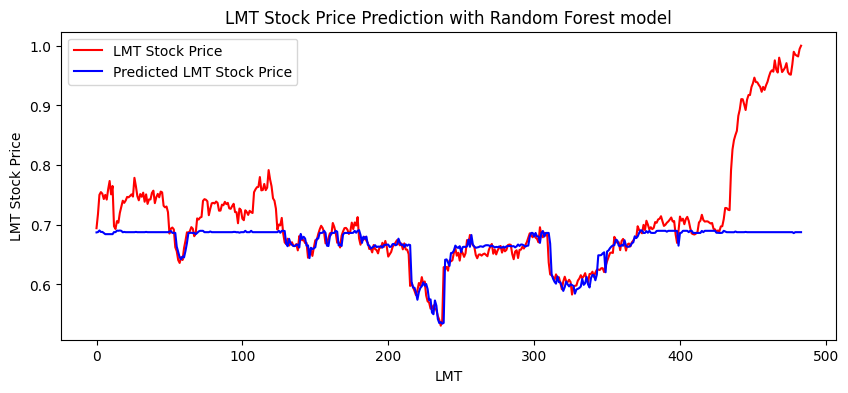

In [ ]:
# Calculating mse, rmse, accuracy percentage for Lockheed Martin Corporation stock with Random Forest model

# Calculating the Mean Squared Error on the test data
randomforest_mse_lmt = mean_squared_error(y_test_lmt, randomforest_lmt.predict(X_test_lmt))
# Calculating the Root Mean Squared Error (RMSE) from MSE
randomforest_rmse_lmt = math.sqrt(randomforest_mse_lmt)
# Calculating the accuracy percentage
rf_accuracy_lmt = 100 - ((randomforest_rmse_lmt / mean_actual_value_lmt) * 100)

# Printing the accuracy percentage for the Random Forest model
print(f"Percentage Accuracy of Random Forest model for Lockheed Martin Corporation Stock: {rf_accuracy_lmt:.2f}%")

# Plotting actual vs predicted for Random Forest model
plt.figure(figsize=(10, 4))
plt.plot(y_test_lmt, color='red', label='LMT Stock Price')
plt.plot(randomforest_lmt.predict(X_test_lmt), color='blue', label='Predicted LMT Stock Price')
plt.title('LMT Stock Price Prediction with Random Forest model')
plt.xlabel('LMT')
plt.ylabel('LMT Stock Price')
plt.legend()
plt.show()

### **SVM**

In [ ]:
# SVM model for Lockheed Martin Corporation stock
svm_model_lmt = svm_hyperparameter_tuning(X_train_lmt, y_train_lmt)


Percentage Accuracy of SVM model for Lockheed Martin Corporation Stock: 95.72%


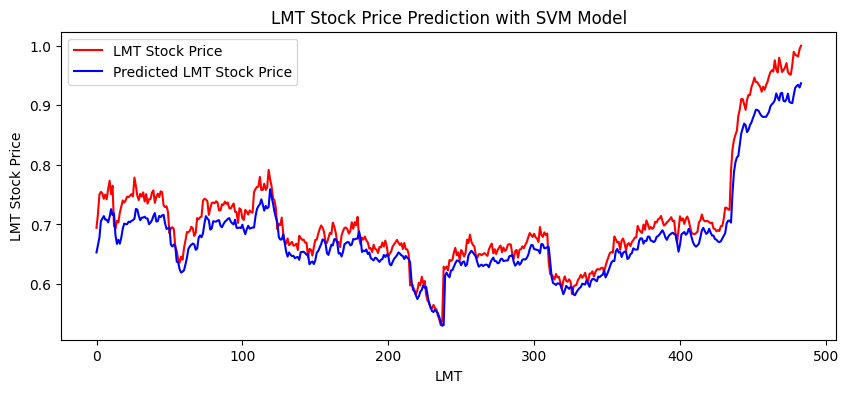

In [ ]:
# Calculating mse, rmse, accuracy percentage for Lockheed Martin Corporation stock with SVM model

# Calculating the Mean Squared Error on the test data
svm_mse_lmt = mean_squared_error(y_test_lmt, svm_model_lmt.predict(X_test_lmt))
# Calculating the Root Mean Squared Error (RMSE) from MSE
svm_rmse_lmt = math.sqrt(svm_mse_lmt)
# Calculating the accuracy percentage
svm_accuracy_lmt = 100 - ((svm_rmse_lmt / mean_actual_value_lmt) * 100)

# Print the accuracy percentage for SVM model
print(f"Percentage Accuracy of SVM model for Lockheed Martin Corporation Stock: {svm_accuracy_lmt:.2f}%")

# Plotting actual vs predicted for SVM model
plt.figure(figsize=(10, 4))
plt.plot(y_test_lmt, color='red', label='LMT Stock Price')
plt.plot(svm_model_lmt.predict(X_test_lmt), color='blue', label='Predicted LMT Stock Price')
plt.title('LMT Stock Price Prediction with SVM Model')
plt.xlabel('LMT')
plt.ylabel('LMT Stock Price')
plt.legend()
plt.show()

### **LSTM**

In [ ]:
# LSTM model for Lockheed Martin Corporation stock

# Scale the feature and target data using the fitted scaler
X_train_lmt_scaled = scaler_lmt.fit_transform(X_train_lmt)
y_train_lmt_scaled = scaler_lmt.fit_transform(y_train_lmt.reshape(-1, 1))

# Split scaled data into training, validation, and testing sets
# First, split into 70% training and 30% temporary set (temp) for further splitting
X_train_l, X_temp_l, y_train_l, y_temp_l = train_test_split(X_train_lmt_scaled, y_train_lmt_scaled, test_size=0.3, random_state=42)
# Next, split the temporary set into 50% validation and 50% testing
X_val_l, X_test_l, y_val_l, y_test_l = train_test_split(X_temp_l, y_temp_l, test_size=0.5, random_state=42)

# Perform grid search to find the best parameters
print("Performing Grid Search for LSTM model ---------------------------")
best_params_lmt = lstm_grid_search(X_train_l, y_train_l, X_val_l, y_val_l, mean_actual_value_lmt)


Performing Grid Search for LSTM model ---------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (32, 32, 0.0005) => MSE: 0.0004, Accuracy: 95.68%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (32, 32, 0.0001) => MSE: 0.0011, Accuracy: 92.65%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (32, 64, 0.0005) => MSE: 0.0005, Accuracy: 94.87%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (32, 64, 0.0001) => MSE: 0.0022, Accuracy: 89.70%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (64, 32, 0.0005) => MSE: 0.0004, Accuracy: 95.72%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (64, 32, 0.0001) => MSE: 0.0008, Accuracy: 93.93%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (64, 64, 0.0005) => MSE: 0.0005, Accuracy: 95.31%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Params: (64, 64, 0.0001) => MSE: 0.0013, Accuracy: 91.96%

Best Parameters-------------------
LSTM Units: 64
Batch Size: 32
Learning Rate: 0.0005


In [ ]:
# Use the best parameters for final training and testing

# Unpack the best hyperparameters from the grid search results
best_lstm_units, best_batch_size, best_learning_rate = best_params_lmt
# Train the final model using the best parameters found during the grid search
print("\nTraining Final Model with Best Parameters---------------------------")
lstm_mse_lmt, lstm_rmse_lmt, lstm_accuracy_lmt, lstm_predictions_lmt = train_final_lstm_model(
        X_train_l, y_train_l, X_test_l, y_test_l,
        best_lstm_units, best_batch_size, best_learning_rate, mean_actual_value_lmt
    )



Training Final Model with Best Parameters---------------------------
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1450
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6838e-04
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5644e-04
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5446e-04
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9795e-04
Epoch 16/50
43

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                       │ (None, 64)                  │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,029 (222.77 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,020 (148.52 KB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step



Final LSTM Model Metrics for Lockheed Martin Corporation------------
MSE of LSTM model for Lockheed Martin Corporation Stock: 0.0003
RMSE of LSTM model for Lockheed Martin Corporation Stock: 0.0172
Accuracy Percentage of LSTM model for Lockheed Martin Corporation Stock: 96.48%


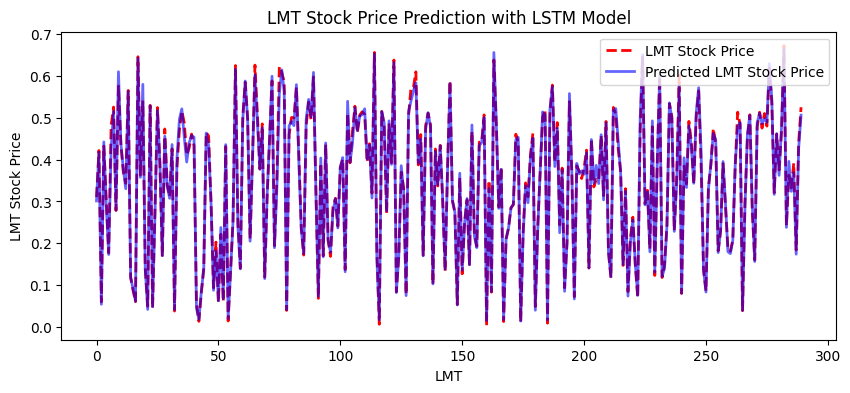

In [ ]:
# Print the final evaluation metrics for the LSTM model
print("\nFinal LSTM Model Metrics for Lockheed Martin Corporation------------")
print(f"MSE of LSTM model for Lockheed Martin Corporation Stock: {lstm_mse_lmt:.4f}")
print(f"RMSE of LSTM model for Lockheed Martin Corporation Stock: {lstm_rmse_lmt:.4f}")
print(f"Accuracy Percentage of LSTM model for Lockheed Martin Corporation Stock: {lstm_accuracy_lmt:.2f}%")


# Inverse transform both y_test and predictions to original scale
y_test_original_lmt = scaler_lmt.inverse_transform(y_test_l.reshape(-1, 1)).flatten()
predictions_original_lmt = scaler_lmt.inverse_transform(lstm_predictions_lmt.reshape(-1, 1)).flatten()

# Plot the actual vs predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test_original_lmt, color='red', label='LMT Stock Price', linestyle='dashed', linewidth=2)
plt.plot(predictions_original_lmt, color='blue', label='Predicted LMT Stock Price', linestyle='solid', linewidth=2, alpha=0.6)
plt.title('LMT Stock Price Prediction with LSTM Model')
plt.xlabel('LMT')
plt.ylabel('LMT Stock Price')
plt.legend()
plt.show()

### **Stacking Model**

In [ ]:
# Stacking model for Lockheed Martin Corporation stock

# Define Random Forest and SVM base models
rf_base_lmt = RandomForestRegressor(
    n_estimators=randomforest_lmt.n_estimators,
    max_depth=randomforest_lmt.max_depth,
    min_samples_split=randomforest_lmt.min_samples_split,
    random_state=40
)

svm_base_lmt = SVR(
    kernel='rbf',
    C=svm_model_lmt.C,
    gamma=svm_model_lmt.gamma,
    epsilon=svm_model_lmt.epsilon
)


# Initialize the LSTM regressor with best parameters
lstm_base_lmt = LSTMRegressor(
    lstm_units=best_lstm_units,
    batch_size=best_batch_size,
    learning_rate=best_learning_rate
)

# Combine the base models into the Stacking Regressor
stacking_regressor_lmt = StackingRegressor(
    estimators=[
        ('random_forest', rf_base_lmt),
        ('svm', svm_base_lmt),
        ('lstm', lstm_base_lmt)
    ],
    final_estimator=Ridge(alpha=1.0)
)

# Fit the stacking regressor on training data
stacking_regressor_lmt.fit(X_train_lmt, y_train_lmt.flatten())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


StackingRegressor(estimators=[('random_forest',
                               RandomForestRegressor(min_samples_split=10,
                                                     random_state=40)),
                              ('svm', SVR(C=100, gamma=0.01)),
                              ('lstm', LSTMRegressor())],
                  final_estimator=Ridge())

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Final Metrics for Stacking Regressor:
MSE: 0.0005
RMSE: 0.0234
Accuracy Percentage: 96.69%


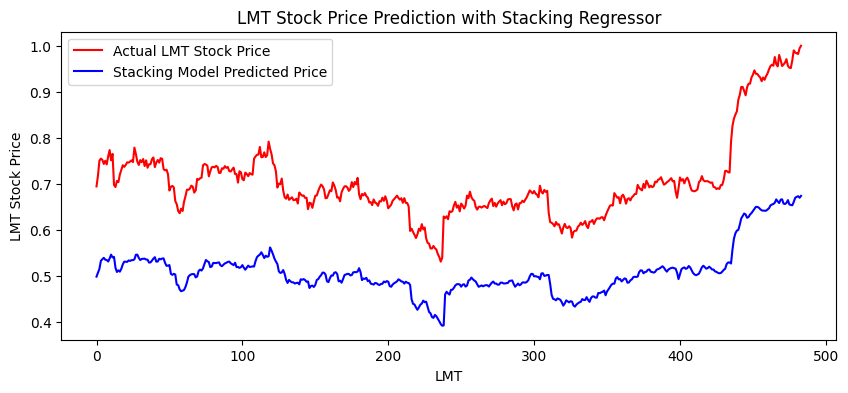

In [ ]:
# Calculating mse, rmse, accuracy percentage for Lockheed Martin Corporation stock with Stacking model

stacking_predictions_lmt = stacking_regressor_lmt.predict(X_test_lmt)
stacking_mse_lmt = mean_squared_error(y_test_lmt, stacking_predictions_lmt)
stacking_rmse_lmt = math.sqrt(stacking_mse_lmt)
stacking_accuracy_lmt = 100 - ((stacking_rmse_lmt / mean_actual_value_lmt) * 100)

# Print final metrics
print("\nFinal Metrics for Stacking Regressor:")
print(f"MSE: {stacking_mse_lmt:.4f}")
print(f"RMSE: {stacking_rmse_lmt:.4f}")
print(f"Accuracy Percentage: {stacking_accuracy_lmt:.2f}%")

# Plot actual vs predicted values for stacking regressor
plt.figure(figsize=(10, 4))
plt.plot(y_test_lmt, color='red', label='Actual LMT Stock Price')
plt.plot(scaler_lmt.inverse_transform(stacking_predictions_lmt.reshape(-1, 1)).flatten(),
         color='blue', label='Stacking Model Predicted Price')
plt.title('LMT Stock Price Prediction with Stacking Regressor')
plt.xlabel('LMT')
plt.ylabel('LMT Stock Price')
plt.legend()
plt.show()

## **Comparing Models**

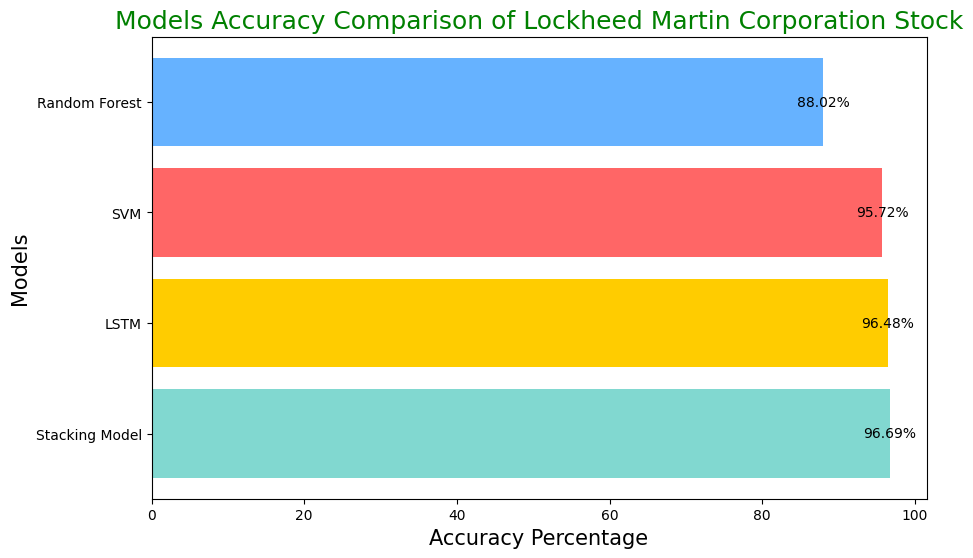

In [ ]:
compares_model_accuracies(
    rf_accuracy=rf_accuracy_lmt,
    svm_accuracy=svm_accuracy_lmt,
    lstm_accuracy=lstm_accuracy_lmt,
    stacking_accuracy=stacking_accuracy_lmt,
    title="Models Accuracy Comparison of Lockheed Martin Corporation Stock"
)